In [8]:
# General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


# Modelling Imports
import sklearn
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import gensim

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D

# Useful relative paths
data_directory = './data/NELA'
model_directory ='./models'

## 1 – Modelling with LSTM!

In [9]:
X = pd.read_csv('{}/complete_processed.csv'.format(data_directory))
y = X['label']
X.drop('label',axis=1)
;

''

In [10]:
full_processed_split=X['full_preprocessed'].apply(lambda x: x.split())
w2v_model = gensim.models.Word2Vec(sentences=full_processed_split, size=100, window=5, min_count=1)

In [11]:
len(w2v_model.wv.vocab)

153239

A little sanity check

In [12]:
w2v_model.wv.most_similar("trump")

[('president', 0.6700112223625183),
 ('obama', 0.6648013591766357),
 ('potus', 0.6444604396820068),
 ('spurns', 0.5876729488372803),
 ('realdonaldtrump', 0.5612344741821289),
 ('democrat', 0.5451527237892151),
 ('republican', 0.5339160561561584),
 ('congress', 0.5272553563117981),
 ('congressional', 0.5220623016357422),
 ('pelosi', 0.5177999138832092)]

Great! makes sense

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_processed_split)
X_lstm = tokenizer.texts_to_sequences(full_processed_split)

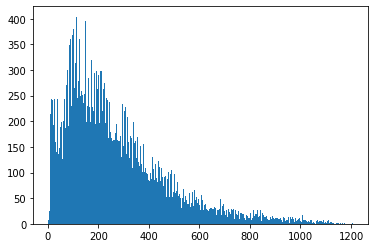

In [14]:
plt.hist([len(x) for x in X_lstm], bins=500)
plt.show() 

In [15]:
nos = np.array([len(x) for x in X_lstm])
len(nos[nos  < 700])

41863

In [16]:
maxlen = 700 

X_lstm = pad_sequences(X_lstm, maxlen=maxlen)

In [17]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [19]:
word_index = tokenizer.word_index
embedding_vectors = get_weight_matrix(w2v_model, word_index)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [20]:
vocab_size = len(word_index) + 1
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 100)          15324000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,441,377
Trainable params: 117,377
Non-trainable params: 15,324,000
_________________________________________________________________


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y) 

In [23]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
722/722 [==============================] - 468s 649ms/step - loss: 0.4753 - acc: 0.7620 - val_loss: 0.4317 - val_acc: 0.7845
Epoch 2/6
722/722 [==============================] - 478s 662ms/step - loss: 0.3954 - acc: 0.8146 - val_loss: 0.4051 - val_acc: 0.8028
Epoch 3/6
414/722 [================>.............] - ETA: 3:17 - loss: 0.3660 - acc: 0.8292

E1202 22:17:03.933016 4736566720 ultratb.py:152] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-a34c9ac7c1a9>", line 1, in <module>
    model.fit(X_train, y_train, validation_split=0.3, epochs=6)
  File "//anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "//anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1098, in fit
    tmp_logs = train_function(iterator)
  File "//anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "//anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 807, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "//anaconda3/lib/pyth

TypeError: object of type 'NoneType' has no len()

In [35]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      5604
           1       0.82      0.84      0.83      5374

    accuracy                           0.83     10978
   macro avg       0.83      0.83      0.83     10978
weighted avg       0.83      0.83      0.83     10978



In [37]:
model.save('models/LSTM/')

In [40]:
model1 = keras.models.load_model('models/LSTM/')

In [42]:
y_pred = (model1.predict(X_test) >= 0.5).astype("int")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      5604
           1       0.82      0.84      0.83      5374

    accuracy                           0.83     10978
   macro avg       0.83      0.83      0.83     10978
weighted avg       0.83      0.83      0.83     10978

